In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import camb
from tqdm import tqdm
import healpy
import pickle

2024-03-04 21:15:55.936660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


In [20]:
import camb
def sim_1d(param, cl_hat = False):
    # Create a set of cosmological parameters
    pars = camb.CAMBparams()
    H0 = param[0] * 100
    pars.set_cosmology(H0=H0)
    pars.set_for_lmax(2500, lens_potential_accuracy=0)

    # Get the results from CAMB
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    total = powers['total']
    cl = total[:, 0]
    if cl_hat is True:
        nside = 1024
        cmb_map = hp.sphtfunc.synfast(cl, nside=nside)
        cl_hats = hp.sphtfunc.anafast(cmb_map)
        return cl_hats[2:2500]
    else:
        return cl[2:]


# Define your simulation function
def simulation_wrapper(param):
    return sim_1d(param)
# Your observed parameter values
observed_params = torch.tensor([0.676])

# Generate the observed dataset
observed_dataset = simulation_wrapper(observed_params)
print(observed_dataset )

[1007.6374839   950.36464964  894.37199078 ...   60.79058422   60.67134573
   60.55358025]


In [20]:
parameter_min = [0.50]
parameter_max = [0.90]

prior = utils.BoxUniform(low=torch.as_tensor(parameter_min),
                         high=torch.as_tensor(parameter_max))


num_sim = [3000, 4000, 6000]
print(num_sim)
posteriors = []
for num in tqdm(num_sim):
    posteriors.append(infer(simulation_wrapper, prior, method='SNPE', num_simulations=num, num_workers=1))

num_samples = 100000

samples_list = []
for posterior in posteriors:
    samples = posterior.sample((num_samples,), x=observed_dataset)
    samples_list.append(samples)

np.save('samples_list_1d_v2.npy', num_samples)

with open(f'posteriors_list_v2.pkl', 'wb') as file:
    pickle.dump(posteriors, file)


[3000, 4000, 6000]


  0%|          | 0/3 [00:00<?, ?it/s]

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

/Users/aisulu/anaconda3/envs/myenv/lib/python3.8/site-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Training neural network. Epochs trained: 51

 33%|███▎      | 1/3 [51:37<1:43:15, 3097.67s/it]

 Neural network successfully converged after 52 epochs.

Running 4000 simulations.:   0%|          | 0/4000 [00:00<?, ?it/s]

 Training neural network. Epochs trained: 47

 67%|██████▋   | 2/3 [1:57:49<1:00:11, 3611.66s/it]

 Neural network successfully converged after 48 epochs.

Running 6000 simulations.:   0%|          | 0/6000 [00:00<?, ?it/s]

 Training neural network. Epochs trained: 60

100%|██████████| 3/3 [3:46:05<00:00, 4521.76s/it]  

 Neural network successfully converged after 61 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

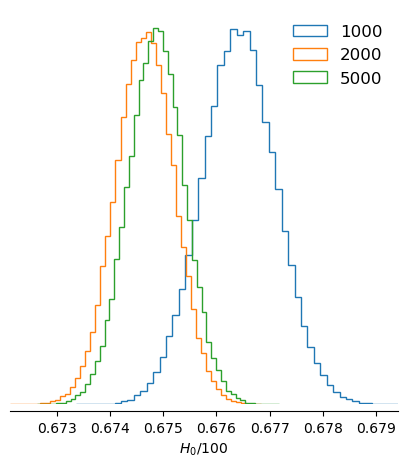

In [21]:
_ = analysis.pairplot(samples_list, labels=[r"$H_0 / 100$"], figsize=(5,5))
plt.legend(
    ["1000", "2000", "5000"],
    frameon=False,
    fontsize=12,
);

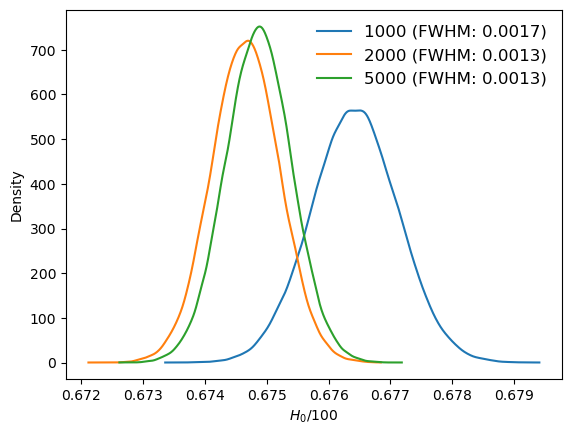

In [22]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Example samples arrays
# samples_1000, samples_2000, samples_5000 = ...

def estimate_fwhm(samples):
    samples = samples.flatten()
    kde = gaussian_kde(samples)
    x_grid = np.linspace(samples.min(), samples.max(), 1000)
    density = kde.evaluate(x_grid)
    max_density = np.max(density)
    half_max_density = max_density / 2

    # Find where the density crosses half the maximum density
    crossing_points = x_grid[np.where(np.diff(np.sign(density - half_max_density)))[0]]
    
    # Assuming the distribution is unimodal and symmetric for simplicity
    if len(crossing_points) >= 2:
        fwhm = crossing_points[-1] - crossing_points[0]
    else:
        fwhm = None  # In case the crossing points are not as expected
    return fwhm, x_grid, density

labels = ["1000", "2000", "5000"]

# Plot KDE and FWHM for each set of samples
for samples, label in zip(samples_list, labels):
    fwhm, x_grid, density = estimate_fwhm(samples)
    plt.plot(x_grid, density, label=f"{label} (FWHM: {fwhm:.4f})")

plt.legend(frameon=False, fontsize=12)
plt.xlabel(r"$H_0 / 100$")
plt.ylabel("Density")
plt.show()


In [27]:
with open(f'posteriors_list.pkl', 'rb') as file:
    post_v1 = pickle.load(file)

In [28]:
with open(f'posteriors_list_v2.pkl', 'rb') as file:
    post_v2 = pickle.load(file)

In [29]:
samples = []
samples.append(post_v1[0].sample((num_samples,), x=observed_dataset))
samples.append(post_v1[1].sample((num_samples,), x=observed_dataset))
samples.append(post_v2[0].sample((num_samples,), x=observed_dataset))
samples.append(post_v2[1].sample((num_samples,), x=observed_dataset))
samples.append(post_v1[2].sample((num_samples,), x=observed_dataset))
samples.append(post_v2[2].sample((num_samples,), x=observed_dataset))


Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

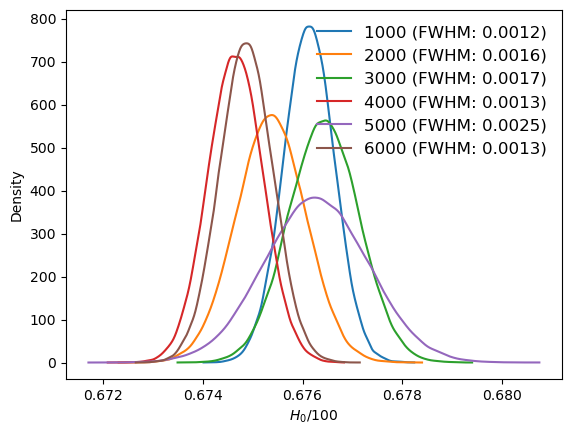

In [30]:
def estimate_fwhm(samples):
    samples = samples.flatten()
    kde = gaussian_kde(samples)
    x_grid = np.linspace(samples.min(), samples.max(), 1000)
    density = kde.evaluate(x_grid)
    max_density = np.max(density)
    half_max_density = max_density / 2

    # Find where the density crosses half the maximum density
    crossing_points = x_grid[np.where(np.diff(np.sign(density - half_max_density)))[0]]
    
    # Assuming the distribution is unimodal and symmetric for simplicity
    if len(crossing_points) >= 2:
        fwhm = crossing_points[-1] - crossing_points[0]
    else:
        fwhm = None  # In case the crossing points are not as expected
    return fwhm, x_grid, density

labels = ["1000", "2000", "3000", "4000", "5000", "6000"]

# Plot KDE and FWHM for each set of samples
for sample, label in zip(samples, labels):
    fwhm, x_grid, density = estimate_fwhm(sample)
    plt.plot(x_grid, density, label=f"{label} (FWHM: {fwhm:.4f})")

plt.legend(frameon=False, fontsize=12)
plt.xlabel(r"$H_0 / 100$")
plt.ylabel("Density")
plt.show()

## FLEXIBLE INTERFACE 

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

In [5]:
num_dim = 5

In [6]:
cls = np.load('cls.npy')
params = np.load('params.npy')
print(params[0])

[7.40143904e+01 3.37263353e-02 3.51219199e-01 2.82219395e+00
 8.24844240e-01]


In [7]:
inference = SNPE()

In [12]:
inference = inference.append_simulations(torch.tensor(params, dtype = torch.float32), torch.tensor(cls, dtype = torch.float32))

In [13]:
density_estimator = inference.train()

 Neural network successfully converged after 129 epochs.

In [16]:
posterior = inference.build_posterior(density_estimator)

In [21]:
posterior.set_default_x(observed_dataset)

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

In [35]:
posterior_samples = posterior.sample((1000,))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

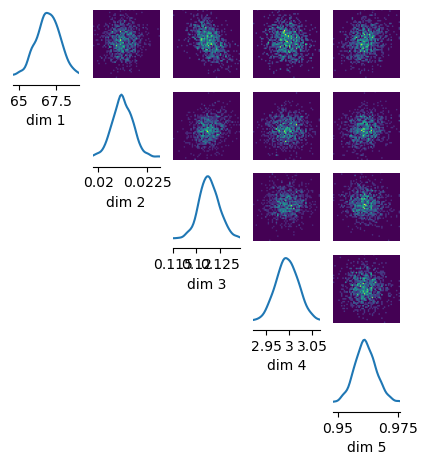

In [36]:
from sbi.analysis import pairplot
fig, ax = pairplot(
    samples=posterior_samples,
    offdiag=["kde"],
    diag=["kde"],
    figsize=(5, 5),
)

In [37]:
from tqdm import tqdm
def some_sim(posterior_samples):
    output = []
    for params in tqdm(posterior_samples):
        pars = camb.CAMBparams()
        H0 = params[0] 
        As = 1e-10*np.exp(params[3])
        pars.set_cosmology(H0=H0, ombh2=params[1], omch2=params[2])
        pars.InitPower.set_params(As=As, ns=params[4])
        pars.set_for_lmax(2500, lens_potential_accuracy=0)

    # Get the results from CAMB
        results = camb.get_results(pars)
        powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
        total = powers['total']
        cl = total[:, 0][100:106]
        output.append(cl)
    return torch.tensor(output)

xpp = some_sim(posterior_samples)

100%|██████████| 1000/1000 [1:05:08<00:00,  3.91s/it]


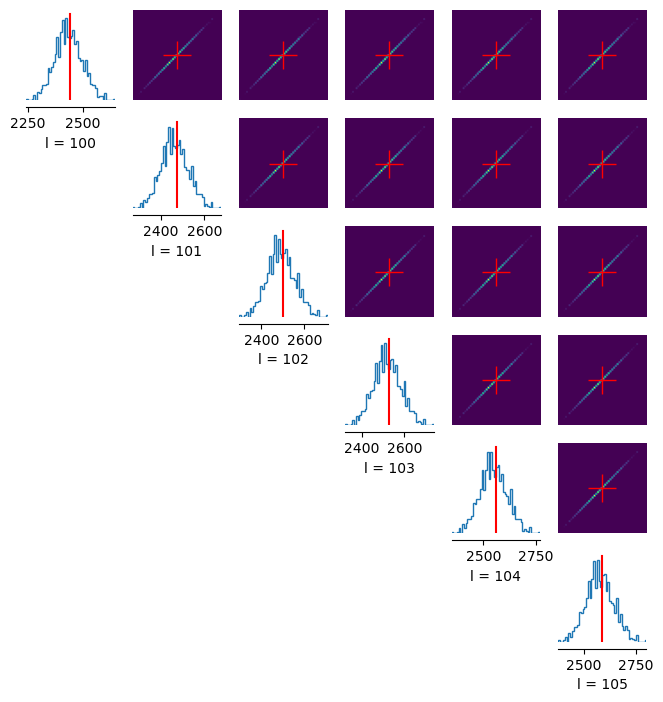

In [45]:
_ = pairplot(
    samples=xpp,
    points=observed_dataset[100-3:106-3],
    points_colors="red",
    figsize=(8, 8),
    offdiag="scatter",
    scatter_offdiag=dict(marker=".", s=5),
    labels = [r"l = 100",r"l = 101",r"l = 102",r"l = 103",r"l = 104" , r"l = 105" ],
    points_offdiag=dict(marker="+", markersize=20),
)

In [46]:
posterior_samples = posterior.sample((100000,))

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [53]:
def simulator(pars_set):
    output = []
    for params in tqdm(pars_set):
        pars = camb.CAMBparams()
        H0 = params[0] 
        As = 1e-10*np.exp(params[3])
        pars.set_cosmology(H0=H0, ombh2=params[1], omch2=params[2])
        pars.InitPower.set_params(As=As, ns=params[4])
        pars.set_for_lmax(2500, lens_potential_accuracy=0)

    # Get the results from CAMB
        results = camb.get_results(pars)
        powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
        total = powers['total']
        cl = total[:, 0]
        output.append(cl)
    return torch.tensor(output)

parameter_min = [50, 0.02, 0.1, 2.8, 0.9]
parameter_max = [90, 0.025, 0.15, 3.2, 1.0]

# Define prior for all parameters
prior = utils.BoxUniform(low=torch.as_tensor(parameter_min),
                         high=torch.as_tensor(parameter_max))


In [54]:
num_sbc_runs = 1_000  # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_sbc_runs,))
xs = simulator(thetas)

100%|██████████| 1000/1000 [33:26<00:00,  2.01s/it]


In [57]:
xs = xs[:, 2:]

In [58]:
from sbi.analysis import check_sbc, run_sbc, get_nltp, sbc_rank_plot
num_posterior_samples = 1_000
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples
)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [59]:
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)

In [60]:
print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)

kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [0.000000e+00 2.687773e-06 0.000000e+00 0.000000e+00 0.000000e+00]


In [61]:
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

c2st accuracies 
check_stats['c2st_ranks'] = [0.722  0.5735 0.69   0.707  0.7425]


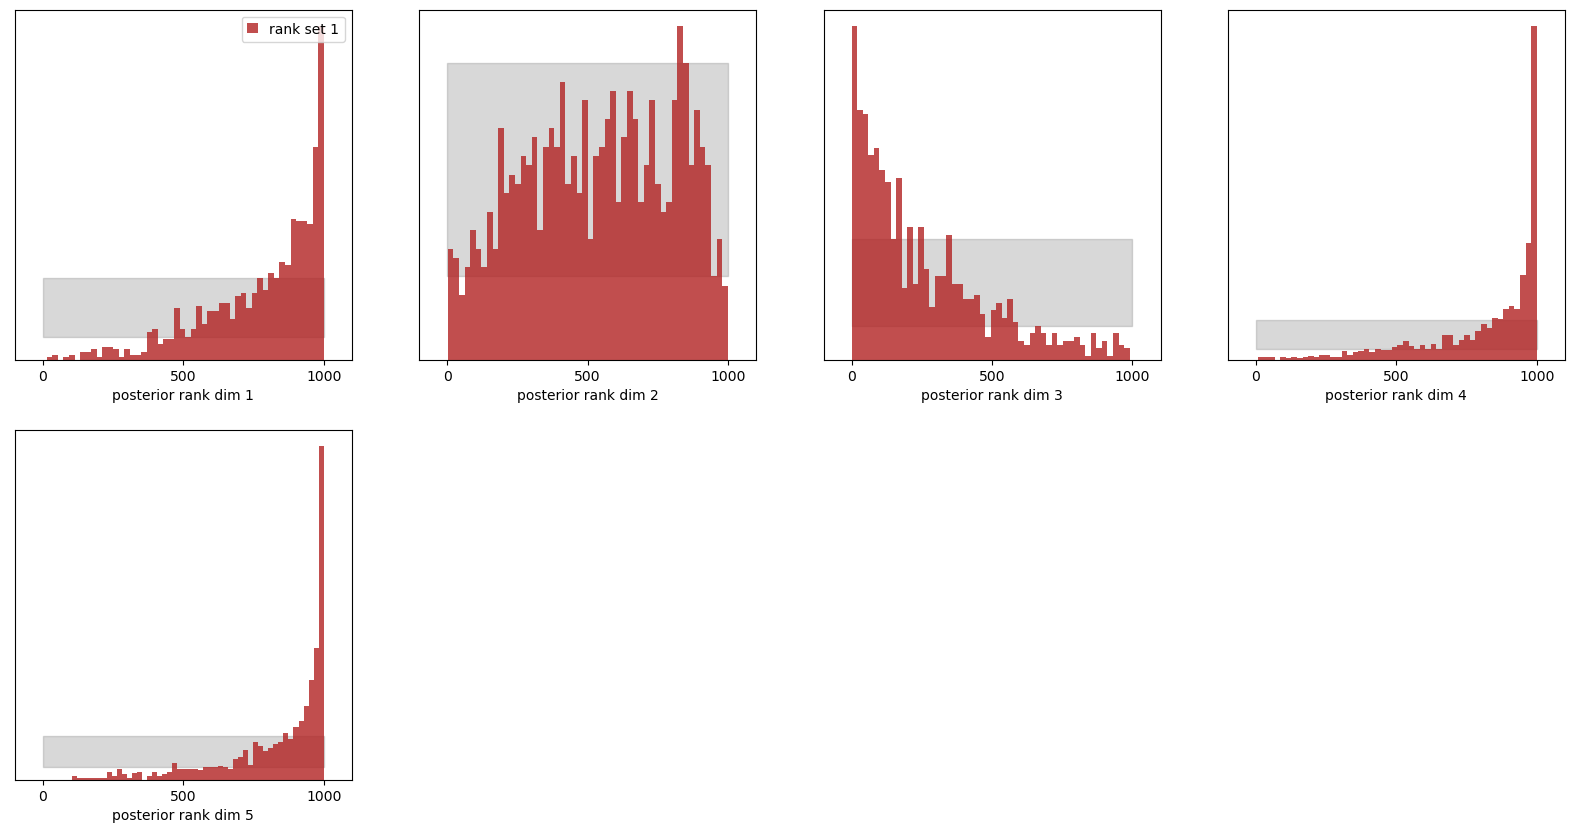

In [62]:
from sbi.analysis import sbc_rank_plot

f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

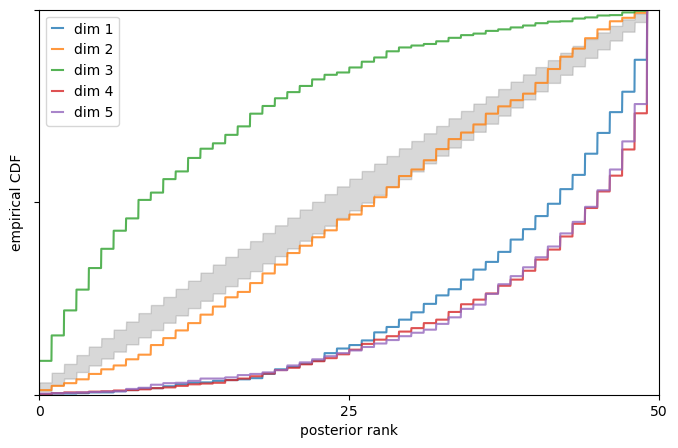

In [63]:

f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")

In [65]:

fig, ax = pairplot(
    samples=xs,
    offdiag="kde",
    diag="kde",
    figsize=(5, 5),
)

KeyboardInterrupt: 

In [1]:
print(xs)

NameError: name 'xs' is not defined

## DOING EVERYTHING AGAIN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import camb
from tqdm import tqdm
import healpy
import pickle
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn

2024-03-09 16:05:26.429818: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
num_dim = 5
cls = np.load('cls.npy')
params = np.load('params.npy')
print(params[0])
inference = SNPE()
inference = inference.append_simulations(torch.tensor(params[:50000], dtype = torch.float32), torch.tensor(cls[:50000], dtype = torch.float32))
density_estimator = inference.train(training_batch_size = 256, learning_rate = 1e-6, stop_after_epochs = 3,show_train_summary = True )

[7.40143904e+01 3.37263353e-02 3.51219199e-01 2.82219395e+00
 8.24844240e-01]
 Neural network successfully converged after 527 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 527
        Best validation performance: 17.8998
        -------------------------
        


In [9]:
pars = camb.CAMBparams()
H0 = 0.676 * 100
pars.set_cosmology(H0=H0)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
total = powers['total']
cl = total[:, 0][2:]
observed_dataset = torch.tensor(cl, dtype = torch.float32)

AttributeError: 'DirectPosterior' object has no attribute 'loss'

In [10]:
posterior = inference.build_posterior(density_estimator)
posterior.set_default_x(observed_dataset)


DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

In [11]:
posterior_samples = posterior.sample((10000,))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

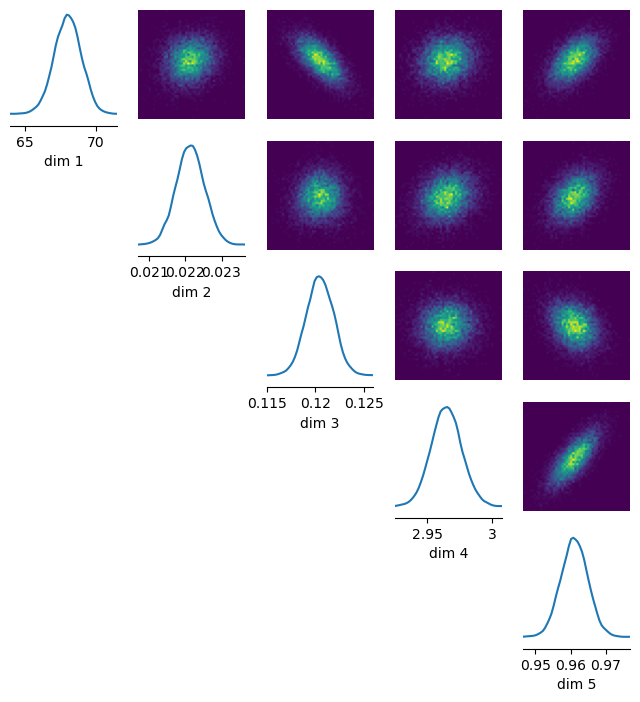

In [12]:
from sbi.analysis import pairplot
fig, ax = pairplot(
    samples=posterior_samples,
    offdiag=["kde"],
    diag=["kde"],
    figsize=(8, 8),
)

In [13]:
import pickle
with open('density_estimator_5000_v4.pkl', "wb") as file:
    pickle.dump(density_estimator, file)

## SBC

In [21]:
def simulator_sbc(thetas):
    output = []
    for params in tqdm(thetas):
        pars = camb.CAMBparams()
        H0 = params[0] 
        As = 1e-10*np.exp(params[3])
        pars.set_cosmology(H0=H0, ombh2=params[1], omch2=params[2])
        pars.InitPower.set_params(As=As, ns=params[4])
        pars.set_for_lmax(2500, lens_potential_accuracy=0)

    # Get the results from CAMB
        results = camb.get_results(pars)
        powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
        total = powers['total']
        cl = total[:, 0][2:]
        output.append(cl)
    return torch.tensor(output, dtype = torch.float32)

parameter_min = [50, 0.02, 0.1, 2.8, 0.9]
parameter_max = [90, 0.025, 0.15, 3.2, 1.0]

prior = utils.BoxUniform(low=torch.as_tensor(parameter_min),
                         high=torch.as_tensor(parameter_max))

In [22]:
num_sbc_runs = 1_000  # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_sbc_runs,))
xs = simulator_sbc(thetas)

100%|██████████| 1000/1000 [29:57<00:00,  1.80s/it]


In [34]:
from sbi.analysis import check_sbc, run_sbc, get_nltp, sbc_rank_plot
num_posterior_samples = 10000
ranks, dap_samples = run_sbc(
    thetas[:101], xs[:101], posterior, num_posterior_samples=num_posterior_samples)
check_stats = check_sbc(ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples)

/Users/aisulu/anaconda3/envs/myenv/lib/python3.8/site-packages/sbi/analysis/sbc.py:56: UserWarning: Number of SBC samples should be on the order of 100s to give realiable
            results. We recommend using 300.
  warnings.warn(


Running 101 sbc samples.:   0%|          | 0/101 [00:00<?, ?it/s]

AssertionError: 

In [ ]:

print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [4.5563524e-33 0.0000000e+00 3.2087173e-28 0.0000000e+00 0.0000000e+00]
c2st accuracies 
check_stats['c2st_ranks'] = [0.5485 0.5355 0.524  0.86   0.591 ]


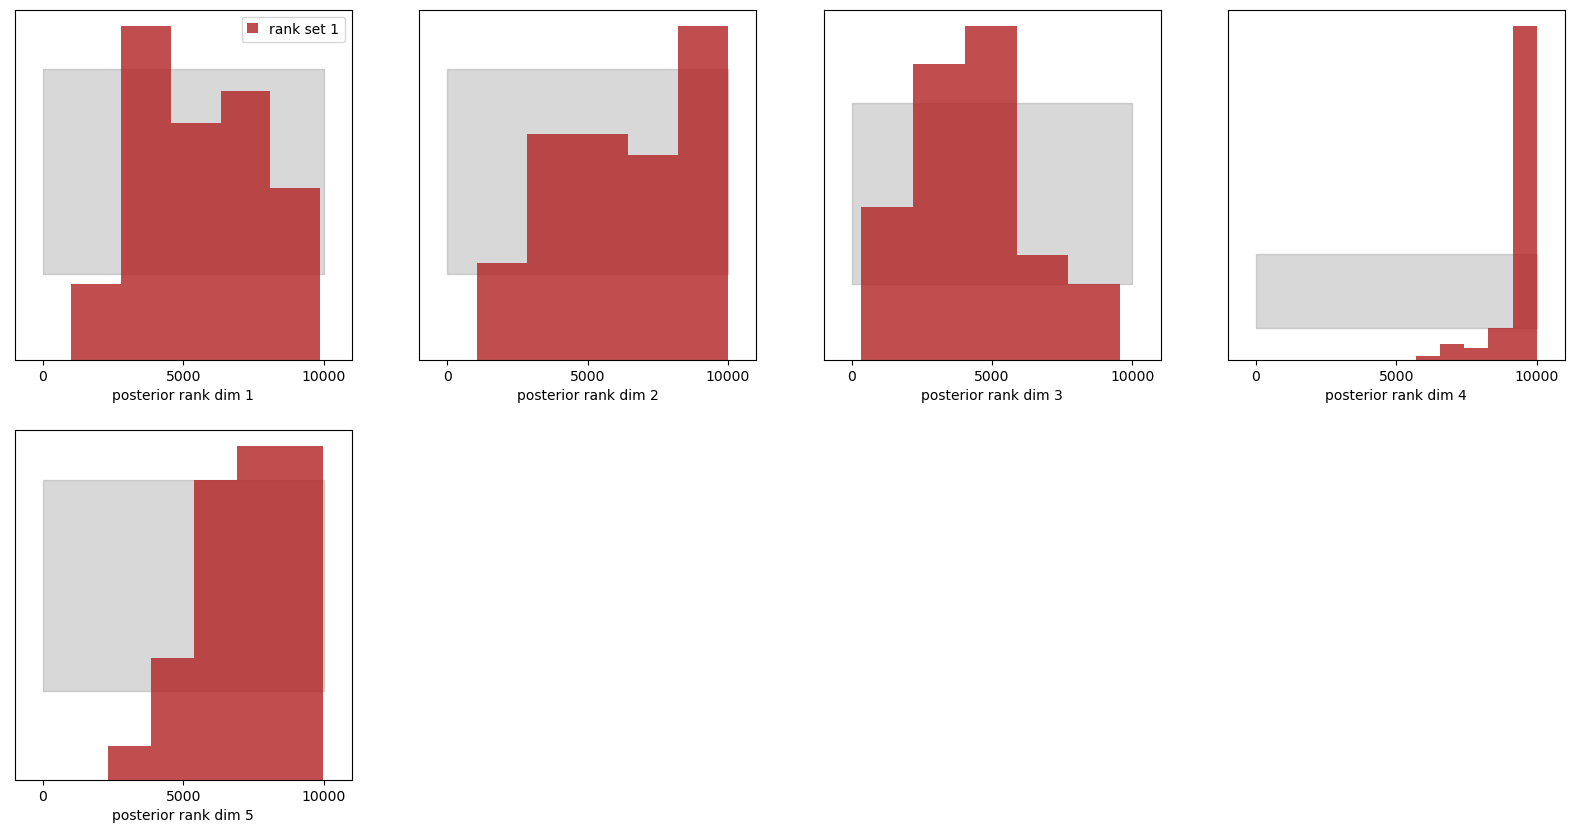

In [35]:
from sbi.analysis import sbc_rank_plot

f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

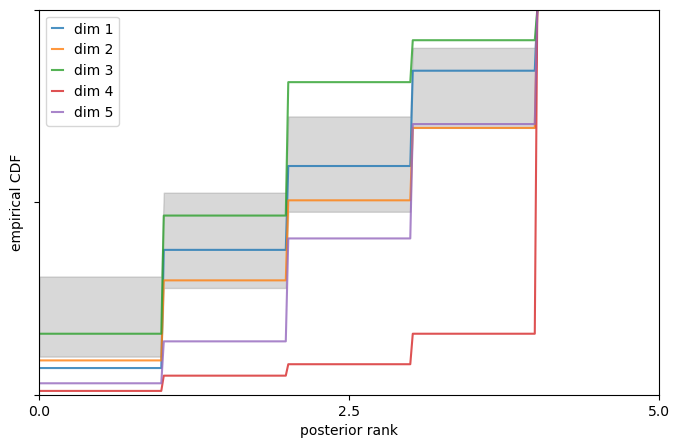

In [36]:

f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")

In [21]:
print(params[0])

[7.40143904e+01 3.37263353e-02 3.51219199e-01 2.82219395e+00
 8.24844240e-01]


(array([7931., 8124., 7985., 8139., 7912., 7913., 8107., 8011., 7895.,
        8013.]),
 array([0.80000089, 0.82000051, 0.84000012, 0.85999974, 0.87999936,
        0.89999898, 0.9199986 , 0.93999822, 0.95999784, 0.97999746,
        0.99999708]),
 <a list of 10 Patch objects>)

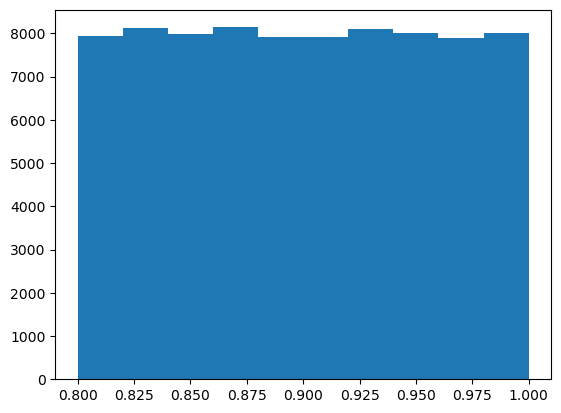

In [26]:
plt.hist(params[:, 4])

In [38]:
np.save('obs.npy', observed_dataset)

In [39]:
with open('density_estimator_5000_v3.pkl', 'rb') as file:
    density_estimator = pickle.load(file)

In [40]:
posterior = inference.build_posterior(density_estimator)
posterior.set_default_x(observed_dataset)

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

In [41]:
posterior_samples = posterior.sample((10000,))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [51]:
np.save('posterior_samples_5000_v3.npy',posterior_samples )

In [44]:
num_sbc_runs = 1_000  # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = torch.tensor(np.load('params.npy')[:num_sbc_runs])
xs = torch.tensor(np.load('cls.npy') [:num_sbc_runs])

In [45]:
from sbi.analysis import check_sbc, run_sbc, get_nltp, sbc_rank_plot
num_posterior_samples = 10000
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples)
check_stats = check_sbc(ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [4.1799827e-05 4.2419438e-03 6.4684049e-05 2.2701999e-04 2.3020269e-01]
c2st accuracies 
check_stats['c2st_ranks'] = [0.5085 0.491  0.4935 0.502  0.5135]


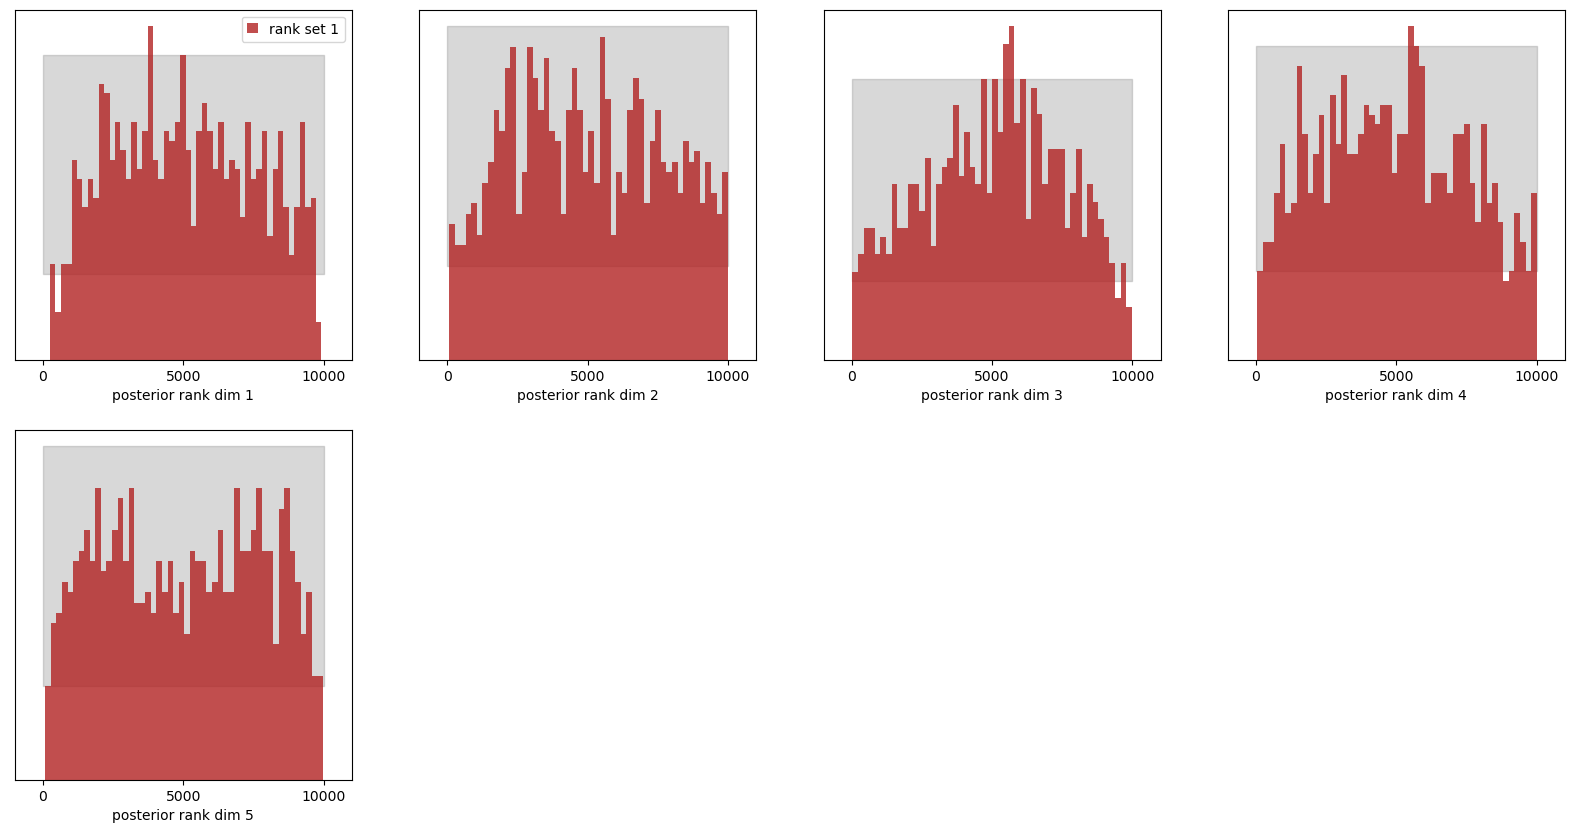

In [46]:

print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)
from sbi.analysis import sbc_rank_plot

f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

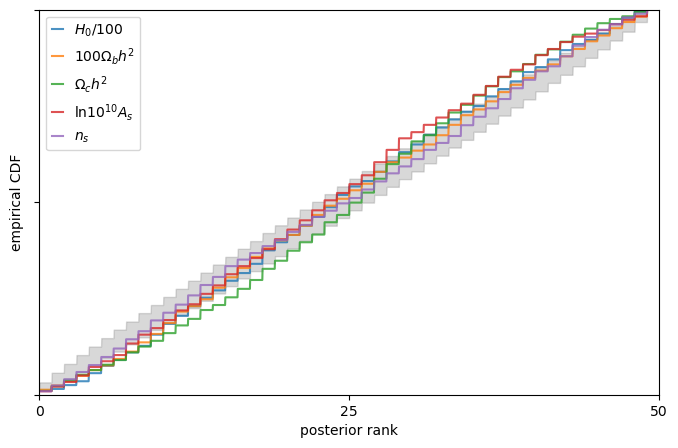

In [52]:
f, ax = sbc_rank_plot(ranks, 1000, plot_type="cdf", 
parameter_labels = [r"$H_0 / 100$", r"$100 \Omega_b h^2$", r'$\Omega_c h^2$', r'$\ln 10^{10} A_s$', r'$n_s$'])
plt.savefig('sbc_check.pdf')

In [74]:
from sbi.analysis import plot_summary
print(density_estimator)

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineTransform()
      (1): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=5, out_features=50, bias=True)
          (context_layer): Linear(in_features=2549, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=50, out_features=10, bias=True)
        )
      )
      (2): RandomPermutation()
      (3): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=5, out_features=50, bias=True)
          (context_layer): Linear(in_features=2549, out_features=50, bias=True)
          (blocks): ModuleList(


In [75]:
print(posterior_samples[0])

tensor([6.8168e+01, 2.2748e-02, 1.1671e-01, 2.9288e+00, 9.6437e-01])
